<a href="https://colab.research.google.com/github/Thamindu17/google-colab/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and Prepare Data

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your CSV file
df = pd.read_csv('large.csv')  # Replace with your filename

Saving large.csv to large (1).csv


# Preprocess the data:

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Convert categorical features (e.g., 'Subject', 'Class') using one-hot encoding
df = pd.get_dummies(df, columns=['Subject', 'Class'])

# Define features (X) and target (y)
X = df.drop('TotalActiveTime', axis=1).values
y = df['TotalActiveTime'].values

# Normalize features (critical for LSTMs)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Weeknumber                   0
TotalActiveTime              0
Subject                      0
Class                        0
SpecialEventThisWeek         0
ResourcesUploadedThisWeek    0
dtype: int64


In [ ]:
df.head()

,Weeknumber,TotalActiveTime,SpecialEventThisWeek,ResourcesUploadedThisWeek,Subject_Science,Class_7-A
0,1,222.9,0,2,True,True
1,2,312.9,1,4,True,True
2,3,308.7,1,1,True,True
3,4,264.7,0,6,True,True
4,5,198.1,0,1,True,True


# Reshape Data for LSTM

In [ ]:
# Reshape into [samples, time_steps, features]
time_steps = 3  # Number of weeks to look back (tune this)
features = X_scaled.shape[1]

# Create sequences
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - time_steps):
    X_sequences.append(X_scaled[i:i+time_steps, :])
    y_sequences.append(y[i+time_steps])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split into train/test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, shuffle=False)

# Build the LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, features), return_sequences=False))
model.add(Dropout(0.2))  # Reduces overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the Model

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]  # Stops training if no improvement
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 67961.1797 - mae: 257.4713 - val_loss: 65810.4453 - val_mae: 251.9051
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 68428.9297 - mae: 258.3571 - val_loss: 65755.8672 - val_mae: 251.7968
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 67109.0625 - mae: 256.2034 - val_loss: 65686.3672 - val_mae: 251.6595
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 67948.8906 - mae: 257.1016 - val_loss: 65599.3984 - val_mae: 251.4878
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 66938.7109 - mae: 255.7119 - val_loss: 65491.6992 - val_mae: 251.2750
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 66957.6094 - mae: 255.6512 - val_loss: 65352.8789 - val_mae: 251.0006
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 68249.8438 - mae: 257.7656 - val_loss: 65162.8555 - val_mae: 250.6250
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 65082.6562 - mae: 252.0042 - val_loss: 64903.3

# Evaluate Performance

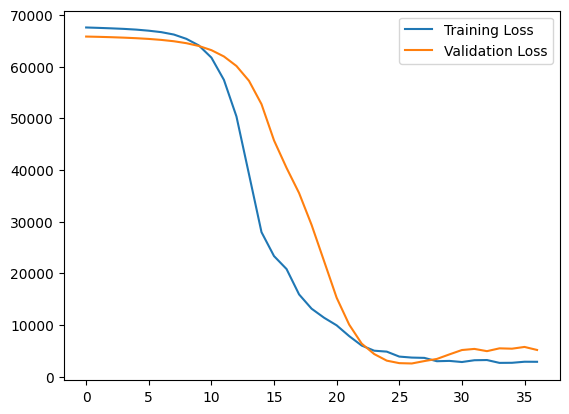

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
MAE: 61.15638135274252
RMSE: 71.95151447918234


In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Predict on test data
y_pred = model.predict(X_test)

# Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

#  Make Future Predictions

In [ ]:
# Use the last 'time_steps' weeks of data
last_sequence = X_scaled[-time_steps:].reshape(1, time_steps, features)
predicted_value = model.predict(last_sequence)[0]
print(f"Predicted Active Time: {predicted_value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
Predicted Active Time: [305.00885]
